# Cyberbullying Detection across Social Media Platforms using Transformers👤⌨️🧑‍💻

## Retrieving the Data📩🔢

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #for use of sns theme in plots
# I use the following Dataset from Kaggle:
#Author: LARXEL
#Link : https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification?resource=download
#Licence: Attribution 4.0 International (CC BY 4.0)

df = pd.read_csv('/content/drive/MyDrive/Thesis/cyberbullying_tweets.csv')
#df = pd.read_csv('./cyberbullying_tweets.csv') # to read from local folder

### Check for available GPU

In [5]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print('tensorflow version',tf.__version__)
print("Num GPUs Available: ",tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

tensorflow version 2.9.2
Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [6]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4057517351983962546
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14415560704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11571538141182600164
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

### Preview data

In [7]:
# The dataset contains two columns (tweet_text, cyberbullying_type)
#tweet_text contains the tweet and cyberbullying_type contains the type of bullying (ethnicity,gender,age etc)
df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


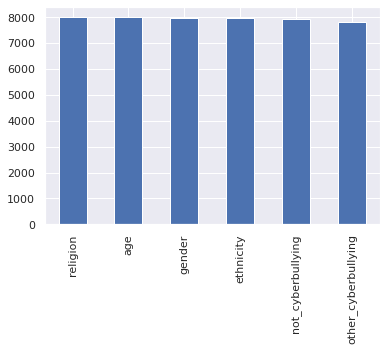

In [8]:
df['cyberbullying_type'].value_counts().plot(kind='bar')

# Data Preprocessing 🔢🔨🪛

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


### Shuffle dataset entries

In [10]:
df = df.sample(frac=1).reset_index(drop=True)

In [12]:
df

,tweet_text,cyberbullying_type
0,"@MvckFadden: Stay beautiful you bitch""""",gender
1,#Coon ass 👎 https://t.co/5BixPnTIEK,other_cyberbullying
2,I should start a drinking game.. Everytime th...,other_cyberbullying
3,"RT @VCR_Blog: #BlameOneNotAll, because if all ...",gender
4,Y’all think rape is cool that’s how i know y’a...,gender
...,...,...
47687,Frio é bullying contra os solteiros. http://t....,not_cyberbullying
47688,@shanley #killallmen,not_cyberbullying
47689,TELL ME MORE @ohthatliamm I'm not sexist but I...,gender
47690,I wanna go to a all white school,not_cyberbullying


### Look for and remove duplicate entries

In [13]:
# Looking for duplicate entries
df.duplicated().sum()

36

In [14]:
# Removing duplicates
df = df[~df.duplicated()]

In [17]:
df['cyberbullying_type'].value_counts()

religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

### Cleaning Text

In [18]:
# Importing libraries needed for cleaning text
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
stop = stopwords.words('english')

import re

df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,tweet_text,cyberbullying_type
0,"@MvckFadden: Stay beautiful you bitch""""",gender
1,#Coon ass 👎 https://t.co/5BixPnTIEK,other_cyberbullying
2,I should start a drinking game.. Everytime th...,other_cyberbullying
3,"RT @VCR_Blog: #BlameOneNotAll, because if all ...",gender
4,Y’all think rape is cool that’s how i know y’a...,gender


In [19]:
#Remove stopwords
def remove_stopwords(text):
  text = ' '.join([word for word in text.split() if word not in stop])
  return text

In [20]:
# Remove '#' and '@'
def remove_hashtags(text):
  #text_new = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', str(text)))
  text_new = " ".join(word.strip() for word in re.split('#|@', str(text)))
  return text_new

In [21]:
# Stemming
from nltk.stem import PorterStemmer
def stemming(text):
    tokenized = nltk.word_tokenize(text)
    pst = PorterStemmer()
    return ' '.join([pst.stem(words) for words in tokenized])

In [22]:
# clean_text applies all cleaning functions
def clean_text(text):
  text = remove_stopwords(text)
  text = remove_hashtags(text)
  text = stemming(text)
  return text

In [23]:
# Apply cleaning to each text
cleaned_text = []
for text in df['tweet_text']:
    cleaned_text.append(clean_text(text))

In [24]:
df['cleaned_text'] = cleaned_text
df

<ipython-input-24-6d072723e4bc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_text'] = cleaned_text


,tweet_text,cyberbullying_type,cleaned_text
0,"@MvckFadden: Stay beautiful you bitch""""",gender,mvckfadden : stay beauti bitch '' ''
1,#Coon ass 👎 https://t.co/5BixPnTIEK,other_cyberbullying,coon ass 👎 http : //t.co/5bixpntiek
2,I should start a drinking game.. Everytime th...,other_cyberbullying,i start drink game .. everytim girl compliment...
3,"RT @VCR_Blog: #BlameOneNotAll, because if all ...",gender,"rt vcr_blog : blameonenotal , men judg rapists..."
4,Y’all think rape is cool that’s how i know y’a...,gender,y ’ all think rape cool that ’ s know y ’ all ...
...,...,...,...
47687,Frio é bullying contra os solteiros. http://t....,not_cyberbullying,frio é bulli contra os solteiro . http : //t.c...
47688,@shanley #killallmen,not_cyberbullying,shanley killallmen
47689,TELL ME MORE @ohthatliamm I'm not sexist but I...,gender,tell me more ohthatliamm i 'm sexist i think i...
47690,I wanna go to a all white school,not_cyberbullying,i wan na go white school


In [25]:
df['cyberbullying_type'].value_counts()

religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

### Check and remove duplicates after cleaning ( Unbalanced data occurs)

In [26]:
# checking for duplicates
#df["cleaned_text"].duplicated().sum()

In [27]:
#df.drop_duplicates("cleaned_text", inplace=True)

In [28]:
# Values after cleaning text and removing duplicates
#df['cyberbullying_type'].value_counts()

### Creating the Dataset (Tokenization, Label Encoding)

In [29]:
seq_len = 512 # number of tokens our tokenizer will create
num_of_samples = len(df) #len of our data
num_of_samples, seq_len

(47656, 512)

In [30]:
!pip install transformers
from transformers import BertTokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 34.6 MB/s 
     |████████████████████████████████| 7.6 MB 66.0 MB/s 
     |████████████████████████████████| 182 kB 76.5 MB/s 


In [31]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #create tokenizer

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [32]:
tokens = tokenizer(df['cleaned_text'].to_list(), max_length = seq_len, 
                   truncation = True, padding = 'max_length', add_special_tokens = True,
                   return_tensors = 'np') #create tokens from tweets

In [33]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [34]:
len(tokens)

3

In [35]:
input_ids = tokens['input_ids']
input_ids

array([[  101, 19842,  3600, ...,     0,     0,     0],
       [  101,  2522,  2239, ...,     0,     0,     0],
       [  101,  1045,  2707, ...,     0,     0,     0],
       ...,
       [  101,  2425,  2033, ...,     0,     0,     0],
       [  101,  1045, 14071, ...,     0,     0,     0],
       [  101,  2112,  4299, ...,     0,     0,     0]])

In [36]:
at_mask = tokens['attention_mask']
at_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [37]:
# Assigning numbers for each label
df['cyberbullying_type'] = df['cyberbullying_type'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4, "other_cyberbullying":5})

<ipython-input-37-f06c6a80cfb6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cyberbullying_type'] = df['cyberbullying_type'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4, "other_cyberbullying":5})


In [38]:
df

,tweet_text,cyberbullying_type,cleaned_text
0,"@MvckFadden: Stay beautiful you bitch""""",3,mvckfadden : stay beauti bitch '' ''
1,#Coon ass 👎 https://t.co/5BixPnTIEK,5,coon ass 👎 http : //t.co/5bixpntiek
2,I should start a drinking game.. Everytime th...,5,i start drink game .. everytim girl compliment...
3,"RT @VCR_Blog: #BlameOneNotAll, because if all ...",3,"rt vcr_blog : blameonenotal , men judg rapists..."
4,Y’all think rape is cool that’s how i know y’a...,3,y ’ all think rape cool that ’ s know y ’ all ...
...,...,...,...
47687,Frio é bullying contra os solteiros. http://t....,4,frio é bulli contra os solteiro . http : //t.c...
47688,@shanley #killallmen,4,shanley killallmen
47689,TELL ME MORE @ohthatliamm I'm not sexist but I...,3,tell me more ohthatliamm i 'm sexist i think i...
47690,I wanna go to a all white school,4,i wan na go white school


### Creating Labels

In [39]:
arr = df['cyberbullying_type'].values

In [40]:
arr.shape

(47656,)

In [41]:
arr

array([3, 5, 5, ..., 3, 4, 1])

In [42]:
arr.max()+1

6

In [43]:
labels = np.zeros((num_of_samples, arr.max()+1))
labels.shape

(47656, 6)

In [44]:
labels[np.arange(num_of_samples), arr] = 1

# Creating Tensorflow Dataset object ➡️⬅️

In [45]:
import tensorflow as tf

In [46]:
data = tf.data.Dataset.from_tensor_slices((input_ids, at_mask, labels))

In [47]:
data.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(6,), dtype=tf.float64, name=None))>

In [48]:
def map_func(input_ids, masks, labels):
  return {'input_ids': input_ids,'attention_mask': masks}, labels

In [49]:
#{input_ids, at_mask} , outputs
data = data.map(map_func)
data.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int64, name=None)}, TensorSpec(shape=(6,), dtype=tf.float64, name=None))>

In [50]:
batch_size = 16
train_split = 0.8
val_split = 0.1
test_split = 0.1
size = int(input_ids.shape[0] / batch_size)

train_size = int(train_split * size)
val_size = int(val_split * size)

In [51]:
data = data.shuffle(3000).batch(batch_size, drop_remainder = True)

In [52]:
data.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 6), dtype=tf.float64, name=None))>

In [53]:
train_ds = data.take(train_size)    
val_ds = data.skip(train_size).take(val_size)
test_ds = data.skip(train_size).skip(val_size)

In [54]:
for ele in test_ds.take(1):
    print(ele[0]['input_ids'])

tf.Tensor(
[[  101  3565 23058 ...     0     0     0]
 [  101 10439  2906 ...     0     0     0]
 [  101  2052 14689 ...     0     0     0]
 ...
 [  101 16244  3207 ...     0     0     0]
 [  101 11199  8804 ...     0     0     0]
 [  101  6616  2833 ...     0     0     0]], shape=(16, 512), dtype=int64)


In [55]:
test_ds_x = []
test_ds_y = []
for item in test_ds:
    test_ds_x.append(item[0])
    test_ds_y.append(item[1])

In [56]:
len(test_ds)

299

In [57]:
len(test_ds_x)

299

# Building Model🔨🧑‍💻

In [58]:
from transformers import TFAutoModel

In [59]:
bert = TFAutoModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [60]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


In [61]:
# two inputs
input_ids = tf.keras.layers.Input(shape = (512,), name = 'input_ids', dtype = 'int32')
mask = tf.keras.layers.Input(shape = (512,), name = 'attention_mask', dtype = 'int32')
# transformer
embeddings = bert.bert(input_ids, attention_mask = mask) [1] # index 1 for MaxPooling
# classifier_head
x = tf.keras.layers.Dense(1024, activation ='relu')(embeddings)
y = tf.keras.layers.Dense(6, activation = 'softmax', name = 'outputs')(x)

In [62]:
model = tf.keras.Model(inputs = [input_ids, mask], outputs = y)
model.layers[2].trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

## Training Model 🏃⏲️

In [63]:
# initializing training parameters
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)
loss = tf.keras.losses.CategoricalCrossentropy()
accuracy = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

In [68]:
%load_ext tensorboard

In [65]:
from keras.callbacks import TensorBoard
tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
                         write_graph=True,
                         write_images=True)

In [66]:
history = model.fit(train_ds, validation_data = val_ds, epochs = 3, callbacks=[tbCallBack])

Epoch 1/3
2382/2382 [==============================] - 1922s 804ms/step - loss: 1.3495 - accuracy: 0.4916 - val_loss: 1.1156 - val_accuracy: 0.5987
Epoch 2/3
2382/2382 [==============================] - 1914s 804ms/step - loss: 1.0825 - accuracy: 0.5980 - val_loss: 0.9741 - val_accuracy: 0.6399
Epoch 3/3
2382/2382 [==============================] - 1891s 794ms/step - loss: 0.9892 - accuracy: 0.6317 - val_loss: 0.9088 - val_accuracy: 0.6715


In [ ]:
%tensorboard --logdir='./log'

In [99]:
# Save Model
model.save('cyberbullying_model')

# Making Predictions 🔮🔮

### Prediction of test set

In [ ]:
# model = tf.keras.models.load_models('cyberbullying_model')

In [70]:
#select batch
batch_num = 150 # number of batches == test_ds length == 288
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_ds_x[batch_num], test_ds_y[batch_num])
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(test_ds_x[batch_num])
print("predictions shape:", predictions.shape)

Evaluate on test data
1/1 [==============================] - 3s 3s/step - loss: 0.7666 - accuracy: 0.6875
test loss, test acc: [0.76656174659729, 0.6875]
Generate predictions for 3 samples
1/1 [==============================] - 3s 3s/step
predictions shape: (16, 6)


In [71]:
predictions

array([[1.8960613e-01, 6.0025614e-04, 7.8243345e-01, 7.1071349e-03,
        9.2920791e-03, 1.0960926e-02],
       [4.8520796e-02, 1.0768633e-02, 1.0539126e-02, 5.9141386e-02,
        6.6664523e-01, 2.0438482e-01],
       [9.6217310e-01, 8.5446965e-03, 4.7789859e-03, 1.7594712e-02,
        5.0102668e-03, 1.8982012e-03],
       [2.4976904e-02, 4.5508817e-03, 1.5377552e-02, 5.0714564e-02,
        5.1356554e-01, 3.9081457e-01],
       [1.3951007e-02, 4.0485927e-01, 3.6599922e-03, 3.3144597e-02,
        3.8686994e-01, 1.5751521e-01],
       [9.4747198e-01, 1.0967004e-03, 7.3924139e-03, 8.5335728e-03,
        2.2436639e-02, 1.3068655e-02],
       [7.7428341e-02, 1.5151731e-03, 8.3300048e-01, 2.5632687e-02,
        3.0244622e-02, 3.2178767e-02],
       [8.1858176e-01, 2.2259360e-02, 8.8066086e-02, 5.7028987e-02,
        9.2853447e-03, 4.7783977e-03],
       [9.6290135e-01, 2.6952915e-03, 3.1200470e-03, 7.8148535e-03,
        1.4813625e-02, 8.6547723e-03],
       [2.5717078e-02, 4.5163015e-01,

In [72]:
labels_pred = []
for prob in predictions:
  labels_pred.append(np.argmax(prob))

In [73]:
labels_pred

[2, 4, 0, 4, 1, 0, 2, 0, 0, 1, 4, 1, 3, 4, 3, 3]

### Convert test labels to numpy array for any batch to compare with predictions

In [74]:
test_ds_y[batch_num].numpy()

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

In [75]:
num_classes = arr.max()+1

In [76]:
num_test_ds_y = []
for x in range(len(labels_pred)):
  for y in range (num_classes):
    if test_ds_y[batch_num].numpy()[x][y]==1 :
      num_test_ds_y.append(y)

In [77]:
num_test_ds_y

[2, 4, 0, 3, 1, 0, 2, 0, 0, 5, 4, 1, 4, 5, 3, 1]

### Confusion Matrix

In [81]:
confusion_matrix = tf.math.confusion_matrix(num_test_ds_y, labels_pred)
confusion_matrix

<tf.Tensor: shape=(6, 6), dtype=int32, numpy=
array([[4, 0, 0, 0, 0, 0],
       [0, 2, 0, 1, 0, 0],
       [0, 0, 2, 0, 0, 0],
       [0, 0, 0, 1, 1, 0],
       [0, 0, 0, 1, 2, 0],
       [0, 1, 0, 0, 1, 0]], dtype=int32)>

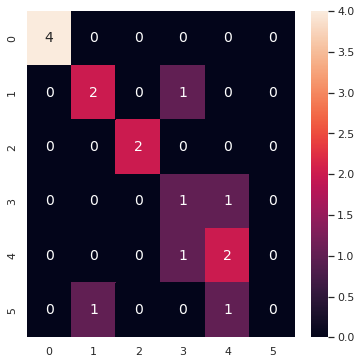

In [97]:
#{'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4, "other_cyberbullying":5}
cm = pd.DataFrame(confusion_matrix.numpy(), range(num_classes),range(num_classes))

plt.figure(figsize = (6,6))
sns.heatmap(cm, annot=True, annot_kws={"size": 14}) # font size
plt.show()

### Prediction of custom input

In [86]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def prep_data(text):
    text = clean_text(text)
    # tokenize to get input IDs and attention mask tensors
    tokens = tokenizer.encode_plus(text, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

In [100]:
#{'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4, "other_cyberbullying":5}
in_tensor = prep_data("i think thats a correct approach man :)")
em = model.predict(in_tensor)[0]
em

1/1 [==============================] - 0s 111ms/step


array([0.04512343, 0.02968352, 0.08911   , 0.08896641, 0.3807273 ,
       0.36638933], dtype=float32)

In [101]:
np.argmax(em)

4